In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import datetime
import seaborn as sns

# ((1)) Imporing Data File

In [2]:
extrel=pd.read_sas('C:/Python Submission/Classification/extrel.sas7bdat')

In [3]:
extrelty=pd.read_sas('C:/Python Submission/Classification/extrelty.sas7bdat')

In [4]:
communication=pd.read_sas('C:/Python Submission/Classification/communication.sas7bdat')

In [5]:
commaint=pd.read_sas('C:/Python Submission/Classification/commaint.sas7bdat')

In [6]:
commediu=pd.read_sas('C:/Python Submission/Classification/commediu.sas7bdat')

In [7]:
comclas=pd.read_sas('C:/Python Submission/Classification/comclas.sas7bdat')

In [8]:
payhistory=pd.read_sas('C:/Python Submission/Classification/payhistory.sas7bdat')

# ((2)) DATA PREPARATION

## Setting Indpendent & Dependent window to find active customers

#### 1 - Start of dependent window = 01 January 2006
#### 2 - End of dependent  window = 03 December 2005
#### 3 - Start of independent window = 01 January 2006

In [9]:
end_window='2005-12-03'
start_window='2006-01-01'

In [10]:
##creating group pf filter data of active customers (as one with - activity code- FP, - start date before end of IW - and end
#date after start of the DW (means he was active during IW) or missing [means still a donor]

### Subsetting the extrel dataset to the approporate window to select donors with commitment-'activated'

In [16]:
    activated=(extrel['EXTRELSTDT']<end_window) & ((extrel['EXRELDATEN']>start_window) |(extrel['EXRELDATEN'].isnull()))\
    & (extrel['EXRELACTCD']==b'FP')

In [17]:
# Applying the activated subset to the extrel table to acquire the details of active member in the appropraite time frame
main_table=extrel[activated]

In [18]:
main_table.head()

,EXTRELNO,EXRELACTCD,EXTRELSTDT,EXRELDATEN
1,b'0026419',b'FP',1992-03-01,NaT
3,b'0026430',b'FP',1992-03-01,2006-01-31
5,b'0026431',b'FP',1992-03-01,NaT
7,b'0026443',b'FP',1992-03-01,NaT
8,b'0026444',b'FP',1992-03-01,NaT


In [19]:
#extracting date from 'EXTRELSTDT' to mark the year of beginning
main_table ['startyr']=main_table['EXTRELSTDT'].apply(lambda x: x.year)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [20]:
# Assigning churners/non churners lables, churners-with date (date of churning) and non churners with NAT ie. still active
main_table['Churn']=np.where(main_table['EXRELDATEN'].isnull(),0,1)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [21]:
# Calculating number of churners and non churners in the time frame

main_table['Churn'].value_counts()

0    6675
1     506
Name: Churn, dtype: int64

### Creating important inidependent variables

In [22]:
# Extracting Last Communication Information
last_communication=communication.sort_values(ascending=0, by='CONTDATE').groupby('EXTRELNO').nth(0)

####  A) Finding total payment made  by each donor

In [23]:
# Finding Total Payment by each donor by aggregating 'PAMT' variable.
Total_Payment=pd.pivot_table(index=['EXTRELNO'],data=payhistory,values=['PAMT'],aggfunc=sum)

In [24]:
# Renaming the PAMT variable to Total_Pamt
Total_Payment=Total_Payment.rename(columns={'PAMT':'Total_Pamt'})

####  B) Recency

In [25]:
#finding most recent date of payment
Recent_payers_by_date=pd.DataFrame(payhistory.groupby('EXTRELNO').apply(lambda x: x['PDATE'].max()),columns=['recent_date'])

In [26]:
Recent_payers_by_date.head()

,recent_date
EXTRELNO,
b'0000019',1993-12-31
b'0000020',2007-01-17
b'0000035',2007-01-17
b'0000042',2001-01-23
b'0000043',2003-07-14


####  C) Frequency

In [27]:
# Frequency of Payments
group_temp=payhistory.groupby('EXTRELNO')

In [28]:
#renaming second column as 'Frequency'
frequent_payers=pd.DataFrame(group_temp.size(),columns=['Frequency'])


### Merging Tables

In [29]:
#Payment & Communication Information
data_frame_temp_1=pd.concat([Total_Payment,Recent_payers_by_date,frequent_payers,last_communication],axis=1)
data_frame_temp_1.shape

(22919, 9)

In [30]:
#Further merging donor information Information
merged_table=main_table.set_index('EXTRELNO').merge(data_frame_temp_1,left_index=True,right_index=True,how='left')

# ((3)) Missing value imputation

Doing imputation seperately - by taking mean/mode of variables where churn is 1 and of variables where churn is 2

### Recent Date (Recency)

In [31]:
cd=merged_table[merged_table['Churn']==1]['recent_date'].mode()[0]

In [32]:
cnd=merged_table[merged_table['Churn']==0]['recent_date'].mode()[0]

In [33]:
merged_table.loc[((merged_table['Churn']==1) & (merged_table['recent_date'].isnull())),'recent_date']=cd

In [34]:
merged_table.loc[((merged_table['Churn']==0) & (merged_table['recent_date'].isnull())),'recent_date']=cnd

In [36]:
#last date of the dump is 2/02/2007
l=datetime.datetime(2007,2,2)
l

datetime.datetime(2007, 2, 2, 0, 0)

In [37]:
#Finding one mode predictor variable'RECENCY' :Time since last payment
merged_table['Recency']=list((map(lambda x: x,l-merged_table['recent_date'])))
merged_table['Recency'].head()

EXTRELNO
b'0026419'    31 days
b'0026430'   472 days
b'0026431'   280 days
b'0026443'    16 days
b'0026444'    16 days
Name: Recency, dtype: timedelta64[ns]

In [38]:
# Retreivig number od days from timedelta object
merged_table['Recency']=merged_table['Recency'].apply(lambda x: x.days)

In [39]:
merged_table['Recency'].head()

EXTRELNO
b'0026419'     31
b'0026430'    472
b'0026431'    280
b'0026443'     16
b'0026444'     16
Name: Recency, dtype: int64

In [40]:
merged_table[merged_table['Total_Pamt'].isnull()].shape

(17, 15)

In [41]:
merged_table[merged_table['Total_Pamt'].isnull()].head()

,EXRELACTCD,EXTRELSTDT,EXRELDATEN,startyr,Churn,Total_Pamt,recent_date,Frequency,CLASCODE,CONTDATE,CONTDIREC,CONTID,MEDIUMCODE,MNTOPCODE,Recency
EXTRELNO,,,,,,,,,,,,,,,
b'0158182',b'FP',2000-02-01,NaT,2000,0,NaN,2007-01-17,NaN,b'ID',2003-04-18,b'O',b'004184524',b'EM',b'REP',16
b'0217927',b'FP',2000-05-01,2006-01-12,2000,1,NaN,2006-12-08,NaN,b'AK',2006-03-15,b'O',b'004978676',b'LE',b'DIS',56
b'0225687',b'FP',2001-12-01,NaT,2001,0,NaN,2007-01-17,NaN,b'ID',2003-09-11,b'O',b'004288013',b'EM',b'REP',16
b'0235523',b'FP',2004-08-01,NaT,2004,0,NaN,2007-01-17,NaN,b'ID',2007-01-11,b'I',b'005165811',b'MR',b'IRE',16
b'0236966',b'FP',2005-01-01,NaT,2005,0,NaN,2007-01-17,NaN,b'ID',2005-01-05,b'O',b'004638245',b'LE',b'INF',16


In [42]:
# dropping end date and recent date
merged_table.drop(['EXRELDATEN','recent_date'],axis=1,inplace=True)

In [43]:
merged_table.head()

,EXRELACTCD,EXTRELSTDT,startyr,Churn,Total_Pamt,Frequency,CLASCODE,CONTDATE,CONTDIREC,CONTID,MEDIUMCODE,MNTOPCODE,Recency
EXTRELNO,,,,,,,,,,,,,
b'0026419',b'FP',1992-03-01,1992,0,3155.05,69.0,b'CT',2006-07-19,b'O',b'005057036',b'CI',b'CTS',31
b'0026430',b'FP',1992-03-01,1992,1,2786.13,146.0,b'AK',2006-03-16,b'O',b'004978998',b'LE',b'DIS',472
b'0026431',b'FP',1992-03-01,1992,0,3050.61,21.0,b'CT',2006-10-05,b'O',b'005103246',b'CI',b'CTS',280
b'0026443',b'FP',1992-03-01,1992,0,3109.62,156.0,b'CT',2006-12-14,b'O',b'005150482',b'CI',b'CTS',16
b'0026444',b'FP',1992-03-01,1992,0,3092.47,157.0,b'CT',2006-06-21,b'O',b'005034575',b'CI',b'CTS',16


### Total Pament

Finding values where values in total payments are less than 0 and deleting those rows

In [44]:
x=merged_table[merged_table['Total_Pamt']<0].index

In [45]:
x

Index([b'0237020', b'0237223', b'0237684', b'0239532', b'0239595', b'0240120'], dtype='object', name='EXTRELNO')

In [46]:
merged_table.drop(x,axis=0,inplace=True)

In [47]:
#found 5 rows and deleted them

In [48]:
#Imputation for churners-Total_Pamt
pc=round(merged_table[merged_table['Churn']==1] ['Total_Pamt'].median(),2)
pc

1834.52

In [49]:
#Imputation for churners-Total_Pamt
pnc=round(merged_table[merged_table['Churn']==0] ['Total_Pamt'].median(),2)
pnc

2424.81

In [50]:
merged_table.loc[((merged_table['Churn']==1) & (merged_table['Total_Pamt'].isnull())),'Total_Pamt']=pc

In [51]:
merged_table.loc[((merged_table['Churn']==0) & (merged_table['Total_Pamt'].isnull())),'Total_Pamt']=pnc

In [52]:
# As there are many extreme values...we will take log of Total_Pamt variable

### Frequency

In [53]:
fc=round(merged_table[merged_table['Churn']==1]['Frequency'].median(),2)
fc

63.0

In [54]:
fnc=round(merged_table[merged_table['Churn']==0]['Frequency'].median(),2)
fnc

77.0

In [55]:
merged_table.loc[((merged_table['Churn']==1) & (merged_table['Frequency'].isnull())),'Frequency']=fc

In [56]:
merged_table.loc[((merged_table['Churn']==0) & (merged_table['Frequency'].isnull())),'Frequency']=fnc

# ((4)) Log Transformation

### Creating box plots for 'Recency','Total Payment' , 'Frequency' and performing Log Transformation if extreme values are found

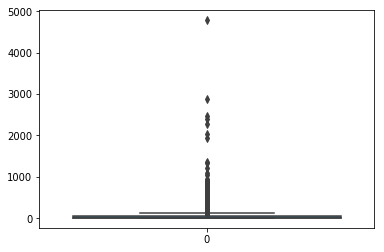

In [57]:
sns.boxplot(data=merged_table.Recency)

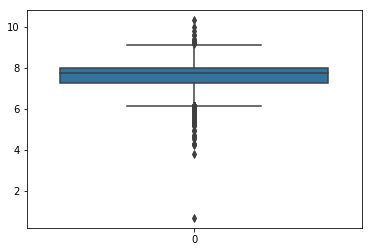

In [58]:
sns.boxplot(data=np.log(merged_table.Total_Pamt))

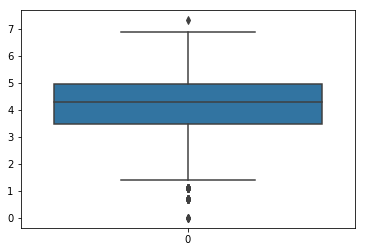

In [59]:
sns.boxplot(data=np.log(merged_table.Frequency))

#### Performing Log Transformations to mitigate effect of extreme values

In [60]:
merged_table['Total_Pamt']=np.log(merged_table['Total_Pamt'])

merged_table.Recency=np.log(merged_table['Recency'])

merged_table.Frequency=np.log(merged_table.Frequency)

## Dropping columns which are not relevant for model

In [61]:
the_table=merged_table.drop(['EXRELACTCD','EXTRELSTDT','CONTDATE','CONTID'],axis=1)

# ((5)) Dummy variable creation for categorical data

In [62]:
table_dummy=pd.get_dummies(the_table)

#  (6)) Spliting data into Train and Test

In [63]:
TRAIN=table_dummy[table_dummy['startyr']<2003]
VALIDATE=table_dummy[table_dummy['startyr']==2004]
TEST=table_dummy[table_dummy['startyr']>2004]

In [64]:
TRAIN_target=TRAIN['Churn']
VALIDATE_target=VALIDATE['Churn']
TEST_target=TEST['Churn']

In [65]:
TRAIN.drop(['Churn','startyr'],axis=1,inplace=True)
VALIDATE.drop(['Churn','startyr'],axis=1,inplace=True)
TEST.drop(['Churn','startyr'],axis=1,inplace=True)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


# ((7)) Scaling Data

In [66]:
from sklearn.preprocessing import StandardScaler

In [67]:
SC=StandardScaler()

In [68]:
TRAIN_Scaled=SC.fit_transform(TRAIN)

In [69]:
TRAIN_Scaled_df=pd.DataFrame(TRAIN_Scaled,columns=TRAIN.columns.tolist())

# ((8)) Dimension Reduction - 
### > Using RFE to find best fetures

#### Checking Co-Reation

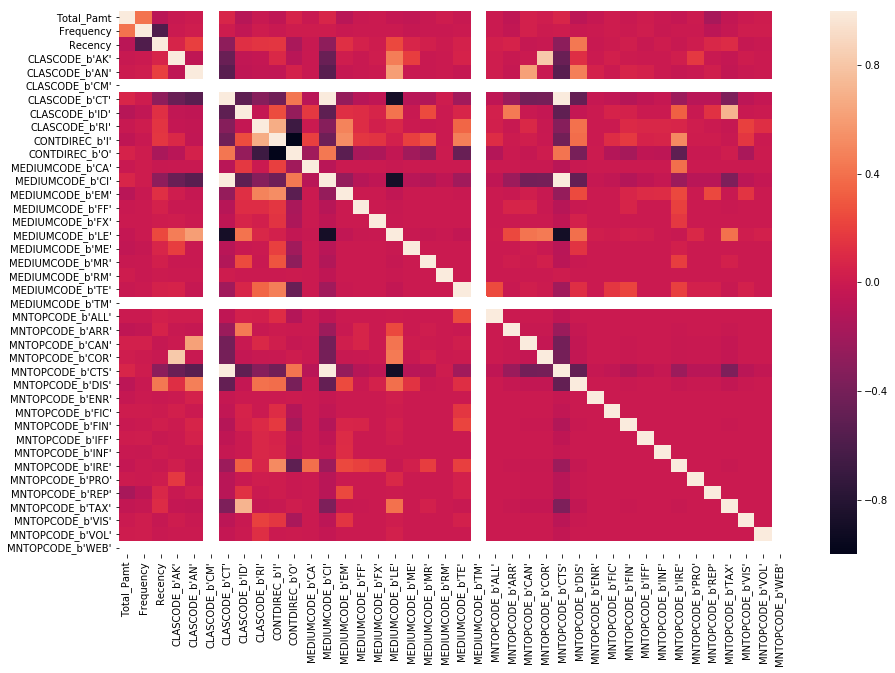

In [70]:
plt.figure(figsize=(15,10))
sns.heatmap(TRAIN_Scaled_df.corr())

###### As Corelation is visible, there is a requirement of variable reduction

In [71]:
from sklearn.feature_selection import RFE
from sklearn import linear_model

In [72]:
linreg_model = linear_model.LinearRegression()

In [73]:
rfe = RFE(linreg_model, 25)

In [75]:
rfe2 = rfe.fit(TRAIN_Scaled_df,TRAIN_target)
rfe2

RFE(estimator=LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False),
  n_features_to_select=25, step=1, verbose=0)

In [76]:
index = TRAIN_Scaled_df.columns[rfe2.support_]
index

Index(['CLASCODE_b'AK'', 'CLASCODE_b'AN'', 'CLASCODE_b'CT'', 'CLASCODE_b'ID'',
       'CLASCODE_b'RI'', 'CONTDIREC_b'I'', 'CONTDIREC_b'O'',
       'MEDIUMCODE_b'TM'', 'MNTOPCODE_b'ALL'', 'MNTOPCODE_b'ARR'',
       'MNTOPCODE_b'CAN'', 'MNTOPCODE_b'COR'', 'MNTOPCODE_b'CTS'',
       'MNTOPCODE_b'DIS'', 'MNTOPCODE_b'ENR'', 'MNTOPCODE_b'FIC'',
       'MNTOPCODE_b'FIN'', 'MNTOPCODE_b'IFF'', 'MNTOPCODE_b'INF'',
       'MNTOPCODE_b'IRE'', 'MNTOPCODE_b'PRO'', 'MNTOPCODE_b'REP'',
       'MNTOPCODE_b'TAX'', 'MNTOPCODE_b'VIS'', 'MNTOPCODE_b'VOL''],
      dtype='object')

#### selecting variables with top 25 highest score features

In [77]:
TRAIN_Scaled_df_25=TRAIN_Scaled_df[index].values

# ((9)) Addressing Class Imbalance Problem

### Resampling data to counter this imbalance by using SMOTE technique

In [78]:
from imblearn.over_sampling import SMOTE
from collections import Counter

In [79]:
smote_x=SMOTE(random_state=3)
X_training_sclaed_resample,Y_training_scaled_resample=smote_x.fit_sample(TRAIN_Scaled_df_25,TRAIN_target.values)

In [81]:
# Checking whether smote has been correctly applied or not

print ("Before SMOTE {}".format(Counter(TRAIN_target.values)))
print ("After SMOTE {}".format(Counter(Y_training_scaled_resample)))

Before SMOTE Counter({0: 5455, 1: 373})
After SMOTE Counter({0: 5455, 1: 5455})


# ((10)) Building Model

In [82]:
from sklearn.linear_model import LogisticRegression
from sklearn.cross_validation import cross_val_score
from sklearn.metrics import confusion_matrix , classification_report
from sklearn.model_selection import GridSearchCV

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


## Method 1- Logistic Regression

### Step 0- Finding C Value using grid Search

## C value is the inverse of regularization

In [83]:
C_Value=LogisticRegression(random_state=5)
grid={'C': [.001,.01,.1,1]}

In [84]:
searchgrid=GridSearchCV(estimator=C_Value,param_grid=grid,cv=5,scoring='recall')

In [85]:
searchgrid.fit(X_training_sclaed_resample,Y_training_scaled_resample)

GridSearchCV(cv=5, error_score='raise',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=5, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'C': [0.001, 0.01, 0.1, 1]}, pre_dispatch='2*n_jobs',
       refit=True, return_train_score='warn', scoring='recall', verbose=0)

In [86]:
searchgrid.grid_scores_

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:761: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


[mean: 0.94005, std: 0.00455, params: {'C': 0.001},
 mean: 0.93694, std: 0.00472, params: {'C': 0.01},
 mean: 0.93419, std: 0.00835, params: {'C': 0.1},
 mean: 0.93437, std: 0.00841, params: {'C': 1}]

In [87]:
searchgrid.best_estimator_

LogisticRegression(C=0.001, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=5, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

##### Best value of C has come up to be 0.001

## Step 1- Training
### Step 1.1- Evaluating Model's Performance

In [88]:
confusion_matrix(y_true=Y_training_scaled_resample,y_pred=searchgrid.best_estimator_.predict(X_training_sclaed_resample))

array([[5198,  257],
       [ 334, 5121]], dtype=int64)

## Step 2- Validating

### Step 2.1 Resampling data to tackle class imabalance

In [89]:
X_validation_resample,Y_validation_resample=smote_x.fit_sample(VALIDATE[index],VALIDATE_target.values)

In [91]:
print ("Before SMOTE {}".format(Counter(VALIDATE_target.values)))
print ("After SMOTE {}".format(Counter(Y_validation_resample)))

Before SMOTE Counter({0: 481, 1: 39})
After SMOTE Counter({0: 481, 1: 481})


### Step 2.2- Sampeling

In [92]:
X_validation_scaled=StandardScaler().fit_transform(X_validation_resample)

### Step 2.3- Evaluating Model's Performance

In [93]:
confusion_matrix(y_pred=searchgrid.best_estimator_.predict(X_validation_scaled),y_true=Y_validation_resample)

array([[479,   2],
       [406,  75]], dtype=int64)

## Step 3- Testing

### Step 3.1 Resampling data to tackle class imabalance

In [94]:
X_test_resample,Y_test_resample=smote_x.fit_sample(TEST[index],TEST_target.values)

### Step 3.2- Scaling

In [95]:
X_test_scaled=StandardScaler().fit_transform(X_test_resample)

### Step 3.3- Evaluating Model's Performance

In [96]:
from sklearn.cross_validation import cross_val_predict

In [97]:
y=cross_val_predict(cv=5,estimator=searchgrid.best_estimator_,X=X_test_scaled,y=Y_test_resample)

In [98]:
confusion_matrix(y_pred=y,y_true=Y_test_resample)

array([[463,   6],
       [279, 190]], dtype=int64)

## Method 2- Random Forrest

In [99]:
from sklearn.ensemble import RandomForestClassifier

In [100]:
random=RandomForestClassifier(n_estimators=50,max_depth=10,random_state=5)

### On validation data

In [101]:
random.fit(X_validation_scaled,Y_validation_resample)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=10, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=50, n_jobs=1,
            oob_score=False, random_state=5, verbose=0, warm_start=False)

In [102]:
Y_predict_val=cross_val_predict(estimator=random,cv=5,X=X_validation_scaled,y=Y_validation_resample)

In [103]:
confusion_matrix(y_pred=Y_predict_val,y_true=Y_validation_resample)

array([[476,   5],
       [ 12, 469]], dtype=int64)

### On test data

In [104]:
Y_predict_test=cross_val_predict(estimator=random,cv=5,X=X_test_scaled,y=Y_test_resample)

In [106]:
print ("Confusion Matrix :- \n",confusion_matrix(y_pred=Y_predict_test,y_true=Y_test_resample))

Confusion Matrix :- 
 [[461   8]
 [ 17 452]]


# Logistic v/s Random Forest

## 1- Matrix Comparison

### Logistic

In [107]:
confusion_matrix(y_pred=y,y_true=Y_test_resample)

array([[463,   6],
       [279, 190]], dtype=int64)

### Random Forest

In [108]:
confusion_matrix(y_pred=Y_predict_test,y_true=Y_test_resample)

array([[461,   8],
       [ 17, 452]], dtype=int64)

In [109]:
from sklearn import metrics

In [111]:
metrics.accuracy_score(y_pred=Y_predict_test,y_true=Y_test_resample)

0.9733475479744137

### Random Forest is a better model with 97% accuracy

# 2- Important Variables Comparison

### Logistic

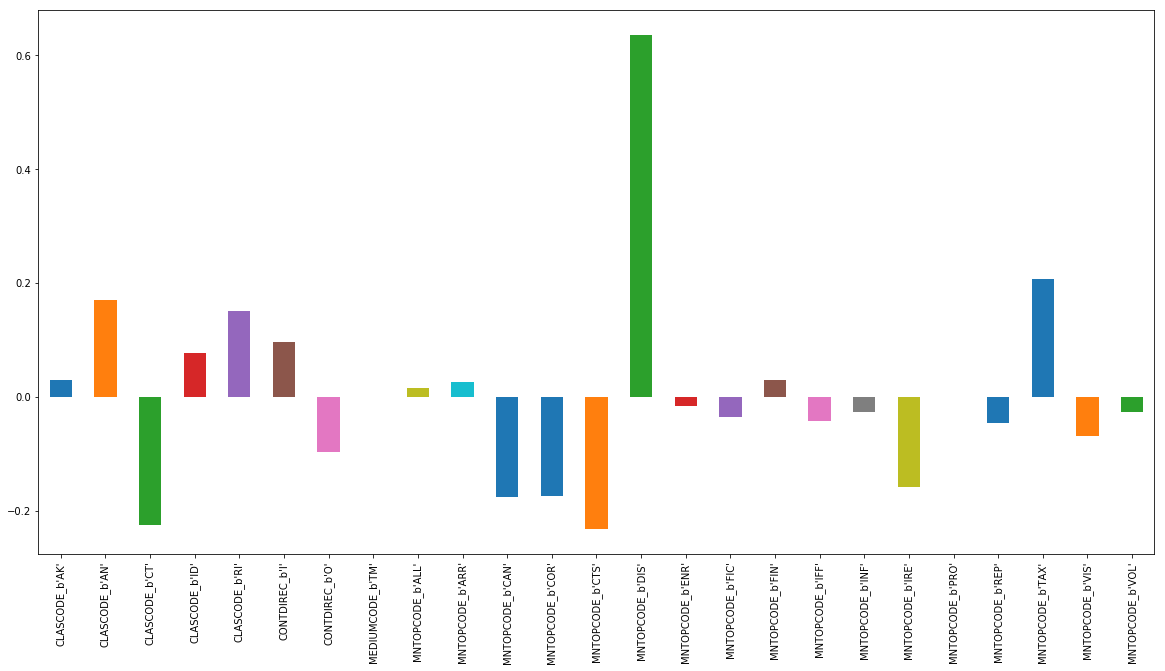

In [112]:
plt.figure(figsize=(20,10))
ax=pd.Series(searchgrid.best_estimator_.coef_.ravel()).plot(kind='bar')
ax.set_xticklabels(index);

### Random Forest

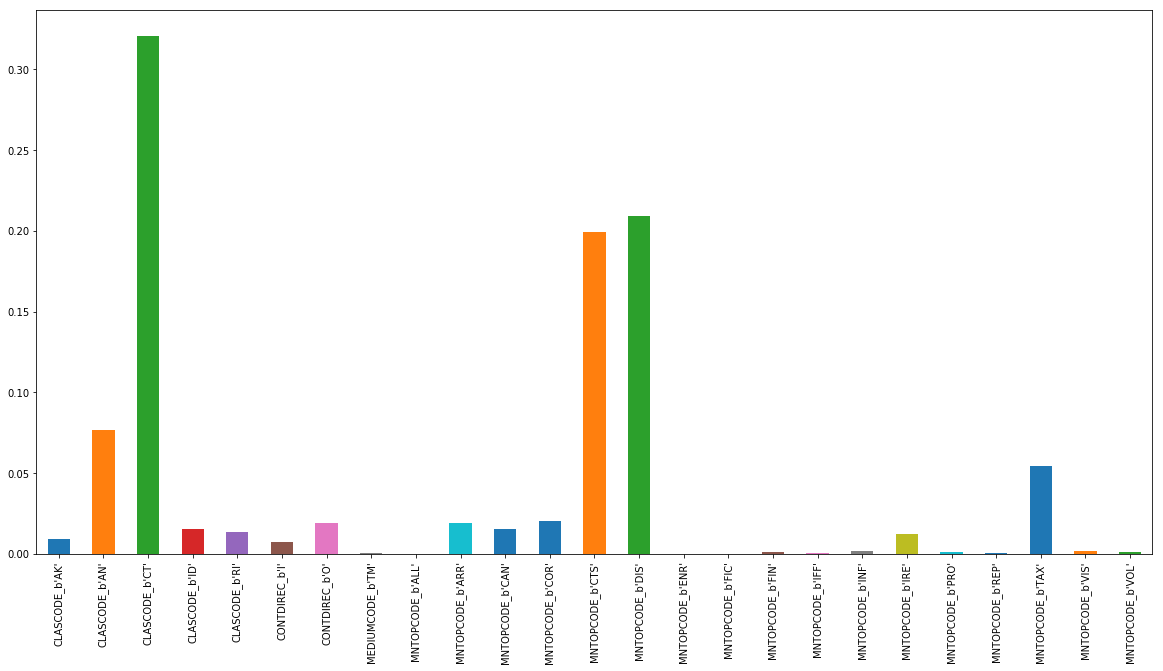

In [113]:
plt.figure(figsize=(20,10))
ax=pd.Series(random.feature_importances_).plot(kind='bar')
ax.set_xticklabels(index);